In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torchvision

In [2]:
dataset_path = r"D:/Datasets/gtsrb/gtsrb"
transform = transforms.Compose(
    [transforms.Resize((32, 32)), transforms.ToTensor()])
data = ImageFolder(root=dataset_path, transform=transform)
n = len(data)
n_test = int(0.1 * n) 
train_data = Subset(data, range(n_test)) 
test_data = Subset(data, range(n_test, n))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data))
number_classes = len(data.classes)

In [3]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv_res1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.conv_res2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 50, kernel_size=3)
    self.bn2 =  nn.BatchNorm2d(50)
    self.conv3 = nn.Conv2d(50, 128, kernel_size=3)
    self.bn3 =  nn.BatchNorm2d(128)

    self.conv_res3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.conv_res4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
    self.bn4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3)
    self.bn5 =  nn.BatchNorm2d(256)

    self.fc1 = nn.Linear(256*22*22, 256)
    self.fc2 = nn.Linear(256, number_classes)

  def resnet_block1(self, x):
    out = F.relu(self.conv_res1(x))
    out = F.relu(self.conv_res2(out))
    return out + x
  
  def conv_block1(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    return x
  
  def resnet_block2(self, x):
    out = F.relu(self.conv_res3(x))
    out = F.relu(self.conv_res4(out))
    return out + x
  
  def conv_block2(self, x):
    x = F.relu(self.bn4(self.conv4(x)))
    x = F.relu(self.bn5(self.conv5(x)))
    return x
  
  def forward(self, x):
    x = self.conv_block1(x)
    x = self.resnet_block1(x)
    x = self.conv_block2(x)
    x = self.resnet_block2(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [4]:
net = Network().cuda()
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters())
num_epochs = 10
loss_memory = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        net.train()
        optimizer.zero_grad()
        inputs, labels = data[0].cuda(), data[1].cuda()
        preds = net(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()
        running_loss =+ loss.item() * inputs.size(0)
        loss_memory.append(running_loss / len(train_data))
        if not i % 100:
            net.eval()
            test_inputs, test_labels = next(iter(test_loader))[0].cuda(), next(iter(test_loader))[1].cuda()
            test_preds = net(inputs)
            test_preds = torch.argmax(test_preds, dim=1)
            correct = sum(test_preds == labels)
            accuracy = (correct.item() / len(labels)) * 100
            print(f"[Epoch {epoch}] Loss: {loss}, Test accuracy: {accuracy} %")

[Epoch 0] Loss: 3.80912709236145, Test accuracy: 57.8125 %
[Epoch 1] Loss: 1.055458426475525, Test accuracy: 85.9375 %
[Epoch 2] Loss: 0.12479907274246216, Test accuracy: 98.4375 %
[Epoch 3] Loss: 0.11325925588607788, Test accuracy: 98.4375 %
[Epoch 4] Loss: 0.0015519261360168457, Test accuracy: 100.0 %
[Epoch 5] Loss: 0.000577390193939209, Test accuracy: 100.0 %
[Epoch 6] Loss: 0.003069758415222168, Test accuracy: 100.0 %
[Epoch 7] Loss: 0.0004661679267883301, Test accuracy: 100.0 %
[Epoch 8] Loss: 0.052321165800094604, Test accuracy: 96.875 %
[Epoch 9] Loss: 2.682209014892578e-06, Test accuracy: 100.0 %


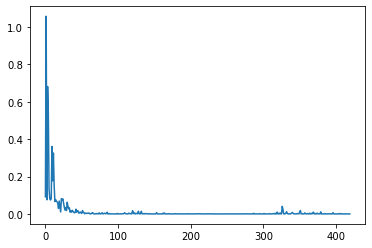

In [6]:
import matplotlib.pyplot as plt

plt.plot(loss_memory)
plt.savefig('train_loss.png', dpi=300, bbox_inches='tight')
plt.show()